#  Setup

In [1]:
!pip install pybaseball
import pybaseball
from pybaseball import statcast, statcast_pitcher, playerid_lookup

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay, f1_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from operator import itemgetter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 8.1 MB/s 
     |████████████████████████████████| 297 kB 46.6 MB/s 
     |████████████████████████████████| 856 kB 47.6 MB/s 


In [2]:
pybaseball.cache.enable()
#data = statcast('2022-04-07', '2022-05-05')
data = statcast('2022-04-07', '2022-10-05')


print(data.shape)
data.head(10)

This is a large query, it may take a moment to complete


100%|██████████| 182/182 [05:03<00:00,  1.67s/it]


(708540, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3141,CH,2022-10-05,80.8,-0.76,6.61,"Baker, Bryan",624415,641329,field_out,hit_into_play,...,5,4,5,4,5,Infield shift,Standard,213,0.035,-0.099
3313,FF,2022-10-05,97.7,-0.58,6.6,"Baker, Bryan",643376,641329,strikeout,swinging_strike,...,5,4,5,4,5,Standard,Standard,189,0.052,-0.134
3449,CH,2022-10-05,84.9,-0.55,6.58,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,212,0.0,0.023
3682,FF,2022-10-05,97.2,-0.42,6.6,"Baker, Bryan",643376,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.036
3820,FC,2022-10-05,86.2,-0.55,6.64,"Baker, Bryan",643376,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,127,0.0,-0.031
3902,FF,2022-10-05,97.5,-0.56,6.68,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,194,0.0,0.023
4113,CH,2022-10-05,84.9,-0.58,6.65,"Baker, Bryan",665489,641329,strikeout,called_strike,...,5,4,5,4,5,Standard,Standard,207,0.071,-0.158
4177,FF,2022-10-05,98.2,-0.59,6.72,"Baker, Bryan",665489,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,190,0.0,0.017
4364,CH,2022-10-05,83.8,-0.41,6.57,"Baker, Bryan",665489,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,211,0.0,-0.046
4592,FF,2022-10-05,96.7,-0.41,6.75,"Baker, Bryan",665489,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.034


# Data Cleaning

## Determining Training Data Columns

In [3]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitch_type', dtype('O'))
('game_date', dtype('<M8[ns]'))
('release_speed', Float64Dtype())
('release_pos_x', Float64Dtype())
('release_pos_z', Float64Dtype())
('player_name', dtype('O'))
('batter', Int64Dtype())
('pitcher', Int64Dtype())
('events', dtype('O'))
('description', dtype('O'))
('spin_dir', Int64Dtype())
('spin_rate_deprecated', Int64Dtype())
('break_angle_deprecated', Int64Dtype())
('break_length_deprecated', Int64Dtype())
('zone', Int64Dtype())
('des', dtype('O'))
('game_type', dtype('O'))
('stand', dtype('O'))
('p_throws', dtype('O'))
('home_team', dtype('O'))
('away_team', dtype('O'))
('type', dtype('O'))
('hit_location', Int64Dtype())
('bb_type', dtype('O'))
('balls', Int64Dtype())
('strikes', Int64Dtype())
('game_year', Int64Dtype())
('pfx_x', Float64Dtype())
('pfx_z', Float64Dtype())
('plate_x', Float64Dtype())
('plate_z', Float64Dtype())
('on_3b', Int64Dtype())
('on_2b', Int64Dtype())
('on_1b', Int64Dtype())
('outs_when_up', Int64Dtype())
('inning', Int64Dtype())
('

https://baseballsavant.mlb.com/csv-docs 

Which columns should we keep based on the documentation? Any metrics derived from the movement of the pitch alone, with no regard for the pitcher who threw it except for the handedness of the pitcher.
  - Motivation: different pitch mixes for different hands of pitchers (e.g. more right-handed changeups than left-handed)

In [4]:
data = data[['pitcher', 'player_name', 'pitch_type', "p_throws",'pitch_name', 'release_spin_rate', 'release_speed','effective_speed', 'spin_axis', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z']]

In [5]:
for i in zip(data.columns, data.dtypes):
  print(i)

('pitcher', Int64Dtype())
('player_name', dtype('O'))
('pitch_type', dtype('O'))
('p_throws', dtype('O'))
('pitch_name', dtype('O'))
('release_spin_rate', Int64Dtype())
('release_speed', Float64Dtype())
('effective_speed', Float64Dtype())
('spin_axis', Int64Dtype())
('vx0', Float64Dtype())
('vy0', Float64Dtype())
('vz0', Float64Dtype())
('ax', Float64Dtype())
('ay', Float64Dtype())
('az', Float64Dtype())
('pfx_x', Float64Dtype())
('pfx_z', Float64Dtype())
('plate_x', Float64Dtype())
('plate_z', Float64Dtype())


In [6]:
pitch_names = data.pitch_name.value_counts()
pitch_names

4-Seam Fastball    232954
Slider             147516
Sinker             111403
Changeup            80275
Curveball           59570
Cutter              50758
Knuckle Curve       13541
Split-Finger        10358
Fastball             1279
Eephus                494
Knuckleball            19
Name: pitch_name, dtype: int64

In [7]:
pitch_types = data.pitch_type.value_counts()
pitch_types

FF    232954
SL    147516
SI    111403
CH     80275
CU     59473
FC     50758
KC     13541
FS     10358
FA      1279
EP       494
CS        97
KN        19
Name: pitch_type, dtype: int64

In [8]:
data[data['pitch_name'] == 'Fastball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
2765,620443,"Torrens, Luis",FA,R,Fastball,2028,88.8,87.4,198,5.908894,-129.211593,-6.160026,-9.017058,23.988244,-16.007847,-0.7,1.34,0.83,2.94
2895,620443,"Torrens, Luis",FA,R,Fastball,2013,87.1,86.0,210,7.76704,-126.695007,-5.562338,-13.780615,23.24916,-19.449337,-1.14,1.09,0.36,2.11
3042,620443,"Torrens, Luis",FA,R,Fastball,2006,84.8,83.5,215,5.576926,-123.404175,-4.159193,-5.468194,23.603541,-16.933643,-0.43,1.43,0.36,2.97
3126,620443,"Torrens, Luis",FA,R,Fastball,1920,85.1,84.2,205,8.035447,-123.70906,-4.118744,-8.74414,22.83086,-21.535999,-0.7,0.97,1.11,2.37
3300,620443,"Torrens, Luis",FA,R,Fastball,1929,86.6,85.1,197,10.013253,-125.686932,-5.303777,-13.215244,24.124622,-19.228439,-1.06,1.13,1.72,2.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,608348,"Kelly, Carson",FA,R,Fastball,1857,78.6,76.1,205,5.157492,-114.128093,-3.105126,-2.84336,26.246587,-16.087129,-0.19,1.82,0.61,3.86
3793,608348,"Kelly, Carson",FA,R,Fastball,1592,65.5,63.3,206,4.6374,-95.083521,-3.870533,-5.016676,17.420544,-21.174033,-0.7,1.76,0.39,1.62
4077,608348,"Kelly, Carson",FA,R,Fastball,1949,79.0,76.6,211,6.208427,-114.661908,-5.294731,-6.994042,25.365648,-17.54007,-0.65,1.58,0.79,2.66
4329,608348,"Kelly, Carson",FA,R,Fastball,1509,65.2,63.4,210,2.917025,-94.862012,-4.324639,-3.695498,16.350107,-21.96135,-0.53,1.62,-0.38,1.32


In [9]:
data[data['pitch_name'] == 'Fastball'].player_name.value_counts()

Alberto, Hanser           151
Gordon, Nick               85
Kelly, Carson              67
VanMeter, Josh             62
Phillips, Brett            59
Harrison, Josh             51
Stubbs, Garrett            45
Brosseau, Mike             44
Myers, Wil                 38
Torrens, Luis              33
Clement, Ernie             32
McKenna, Ryan              31
Hager, Jake                28
Strange-Gordon, Dee        28
Bethancourt, Christian     27
Bradley Jr., Jackie        27
Pinder, Chad               26
Castillo, Diego            26
Schrock, Max               26
Culberson, Charlie         26
Maton, Nick                25
Schwindel, Frank           24
Simmons, Andrelton         21
Reynolds, Matt             20
Pujols, Albert             19
González, Luis             18
Leon, Sandy                17
Castro, Harold             16
Ford, Mike                 15
Plawecki, Kevin            14
Caratini, Victor           14
Dickerson, Corey           12
Merrifield, Whit           12
Molina, Ya

In [10]:
data[data['pitch_name'] == 'Eephus']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
3758,545121,"Vargas, Ildemaro",EP,R,Eephus,841,38.6,37.1,204,0.657855,-54.45668,11.293683,0.051253,5.996353,-30.418288,0.06,1.67,-0.16,4.32
4056,545121,"Vargas, Ildemaro",EP,R,Eephus,812,38.9,37.2,216,-0.237409,-54.731675,12.31373,-0.238409,5.931549,-30.79085,-0.13,1.51,-0.99,5.2
4232,545121,"Vargas, Ildemaro",EP,R,Eephus,898,39.0,37.6,214,1.599343,-55.654232,9.203681,-0.112455,6.065402,-29.648962,0.03,1.86,0.5,2.68
4374,545121,"Vargas, Ildemaro",EP,R,Eephus,786,38.8,37.7,200,-0.054562,-55.025723,10.620663,0.609237,4.665442,-30.573263,0.3,1.33,-0.71,3.81
2847,665019,"Clemens, Kody",EP,R,Eephus,1042,46.1,44.3,201,0.513493,-66.848762,5.700501,-0.052311,5.908564,-28.959118,0.0,1.28,-0.85,3.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,660636,"Castillo, Diego",EP,R,Eephus,1658,67.3,66.6,215,6.064892,-97.949027,0.604866,-1.991434,14.706473,-20.967695,-0.17,1.78,1.63,3.66
2016,571976,"Myers, Wil",EP,R,Eephus,1881,51.5,49.3,29,0.924721,-74.678987,3.75027,3.443837,10.185812,-37.814632,0.96,-1.32,0.52,1.22
2382,571976,"Myers, Wil",EP,R,Eephus,1982,54.6,52.1,41,2.643121,-79.223556,3.304773,2.718303,12.443245,-38.14039,0.76,-1.25,1.46,1.36
2979,571976,"Myers, Wil",EP,R,Eephus,1991,55.3,52.9,35,1.963514,-80.321091,2.368406,3.810391,12.177114,-38.965036,0.96,-1.45,0.83,0.68


In [11]:
data[data['pitch_name'] == 'Eephus'].player_name.value_counts()

Clemens, Kody             86
González, Luis            68
Castro, Harold            34
Castillo, Diego           34
Bethancourt, Christian    25
Neuse, Sheldon            24
Batten, Matthew           23
Chang, Yu                 22
Lopez, Alejo              19
Astudillo, Willians       17
Schwindel, Frank          16
Stubbs, Garrett           15
Ruf, Darin                14
Walton, Donovan           13
VanMeter, Josh            12
Escobar, Alcides           9
Wynns, Austin              9
Reyes, Pablo               8
Arcia, Orlando             8
Sanchez, Carlos            7
Knizner, Andrew            6
Dickerson, Corey           6
Myers, Wil                 5
Vargas, Ildemaro           4
Bradley Jr., Jackie        3
Palacios, Jermaine         3
Gonzalez, Marwin           2
Alberto, Hanser            1
Molina, Yadier             1
Name: player_name, dtype: int64

In [12]:
# Knuckeballs
data[data['pitch_name'] == 'Knuckleball']

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
2811,676391,"Clement, Ernie",KN,R,Knuckleball,1065,49.9,49.3,216,-0.396687,-72.632626,2.717848,-1.610823,8.003952,-28.684959,-0.47,1.12,-2.39,1.3
3268,676391,"Clement, Ernie",KN,R,Knuckleball,1168,53.9,52.1,211,1.539443,-78.019912,6.574567,-3.299501,10.679282,-28.226153,-0.76,1.25,-1.19,5.22
3805,676391,"Clement, Ernie",KN,R,Knuckleball,411,53.7,50.6,152,-1.421582,-76.858301,11.792394,0.412825,12.469656,-32.580382,0.05,0.46,-2.61,7.88
4028,676391,"Clement, Ernie",KN,R,Knuckleball,1105,51.0,49.6,209,2.345995,-74.120517,3.781626,-2.718059,8.595961,-29.513097,-0.66,0.9,-0.51,2.56
4773,676391,"Clement, Ernie",KN,R,Knuckleball,1056,46.9,45.3,202,0.931493,-67.736107,7.751091,-0.549931,6.895081,-30.741344,-0.15,0.78,-0.89,4.43
1398,676391,"Clement, Ernie",KN,R,Knuckleball,1226,52.5,50.5,234,2.899821,-76.104455,4.117468,-4.514909,10.298678,-27.806319,-1.07,1.34,-0.47,3.17
1443,676391,"Clement, Ernie",KN,R,Knuckleball,90,55.2,52.4,342,0.01439,-79.896212,5.281347,-7.300036,14.351981,-31.144068,-1.76,0.55,-3.18,3.33
2038,676391,"Clement, Ernie",KN,R,Knuckleball,2841,50.2,47.1,92,-0.284259,-72.478502,5.370313,0.752915,13.607667,-35.748256,0.21,-0.66,-1.96,0.76
2147,676391,"Clement, Ernie",KN,R,Knuckleball,275,50.3,47.5,213,-1.182588,-72.441673,8.129041,0.8518,11.779551,-32.357822,0.19,0.42,-2.62,4.12
2283,676391,"Clement, Ernie",KN,R,Knuckleball,292,61.0,58.9,238,4.953775,-88.584033,2.117073,-4.101253,14.788409,-33.315609,-0.63,-0.1,0.84,1.54


In [13]:
data[data['pitch_name'] == 'Knuckleball'].player_name.value_counts()

Clement, Ernie      10
Mayfield, Jack       7
Schwindel, Frank     2
Name: player_name, dtype: int64

In [14]:
# number of rows to delete
pitch_names[-3:].sum()

1792

In [15]:
df = data.loc[~((data['pitch_type'] == 'FA') | (data['pitch_type'] == 'EP') | (data['pitch_type'] == 'KN'))]
df.shape

(706748, 19)

In [16]:
print(data.shape[0] - df.shape[0])

1792


In [17]:
df

,pitcher,player_name,pitch_type,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
3141,641329,"Baker, Bryan",CH,R,Changeup,1771,80.8,81.5,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
3313,641329,"Baker, Bryan",FF,R,4-Seam Fastball,2434,97.7,98.1,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
3449,641329,"Baker, Bryan",CH,R,Changeup,1856,84.9,85.2,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3682,641329,"Baker, Bryan",FF,R,4-Seam Fastball,2258,97.2,97.5,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
3820,641329,"Baker, Bryan",FC,R,Cutter,2348,86.2,86.7,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,660271,"Ohtani, Shohei",FS,R,Split-Finger,1314,91.8,93.8,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
1776,660271,"Ohtani, Shohei",SL,R,Slider,2440,86.9,88.6,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
1858,660271,"Ohtani, Shohei",FF,R,4-Seam Fastball,2320,99.2,100.7,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
1924,660271,"Ohtani, Shohei",FF,R,4-Seam Fastball,2164,97.9,99.9,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


## Missing Values

In [18]:
df.isnull().sum()

pitcher                 0
player_name             0
pitch_type            373
p_throws                0
pitch_name            373
release_spin_rate    2288
release_speed         429
effective_speed       503
spin_axis            2310
vx0                   413
vy0                   413
vz0                   413
ax                    413
ay                    413
az                    413
pfx_x                 427
pfx_z                 417
plate_x               413
plate_z               413
dtype: int64

In [19]:
# Example: Find top 10 pitchers with most "missing" spin rate metrics 
df[df['release_spin_rate'].isna()].player_name.value_counts()[:10]

Lodolo, Nick          106
Ashcraft, Graham      104
Smyly, Drew            92
Sampson, Adrian        87
Thompson, Keegan       74
Dunn, Justin           72
Espinoza, Anderson     57
Díaz, Alexis           55
Rucker, Michael        51
Newcomb, Sean          44
Name: player_name, dtype: int64

Option A: Go through all missing metrics for each pitcher, take their averages for each column and fill in all missing values with average

Option B: Delete all rows that contain *any* missing values

In [20]:
# Number of rows with missing values
missing_row_vals = df.isna().any(axis=1).sum()
print(missing_row_vals)
# Error proportion relative to whole regular season dataset
print('Percentage Error of Statcast',round(100 * (missing_row_vals / data.shape[0]), 2))

2472
Percentage Error of Statcast 0.35


In [21]:
# Remove all rows containing missing values
num_rows1 = df.shape[0]

# Drop NaN rows and reset indices
df = df.dropna()
df = df.drop(['pitch_type'], axis=1)
df = df.reset_index(drop = True)

print(df.shape)
print('Number of rows removed:', num_rows1 - df.shape[0])

(704276, 18)
Number of rows removed: 2472


In [22]:
df

,pitcher,player_name,p_throws,pitch_name,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,641329,"Baker, Bryan",R,Changeup,1771,80.8,81.5,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
1,641329,"Baker, Bryan",R,4-Seam Fastball,2434,97.7,98.1,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
2,641329,"Baker, Bryan",R,Changeup,1856,84.9,85.2,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,641329,"Baker, Bryan",R,4-Seam Fastball,2258,97.2,97.5,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
4,641329,"Baker, Bryan",R,Cutter,2348,86.2,86.7,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704271,660271,"Ohtani, Shohei",R,Split-Finger,1314,91.8,93.8,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
704272,660271,"Ohtani, Shohei",R,Slider,2440,86.9,88.6,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
704273,660271,"Ohtani, Shohei",R,4-Seam Fastball,2320,99.2,100.7,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
704274,660271,"Ohtani, Shohei",R,4-Seam Fastball,2164,97.9,99.9,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


In [23]:
df.isnull().sum()

pitcher              0
player_name          0
p_throws             0
pitch_name           0
release_spin_rate    0
release_speed        0
effective_speed      0
spin_axis            0
vx0                  0
vy0                  0
vz0                  0
ax                   0
ay                   0
az                   0
pfx_x                0
pfx_z                0
plate_x              0
plate_z              0
dtype: int64

# Analysis

## Visualization

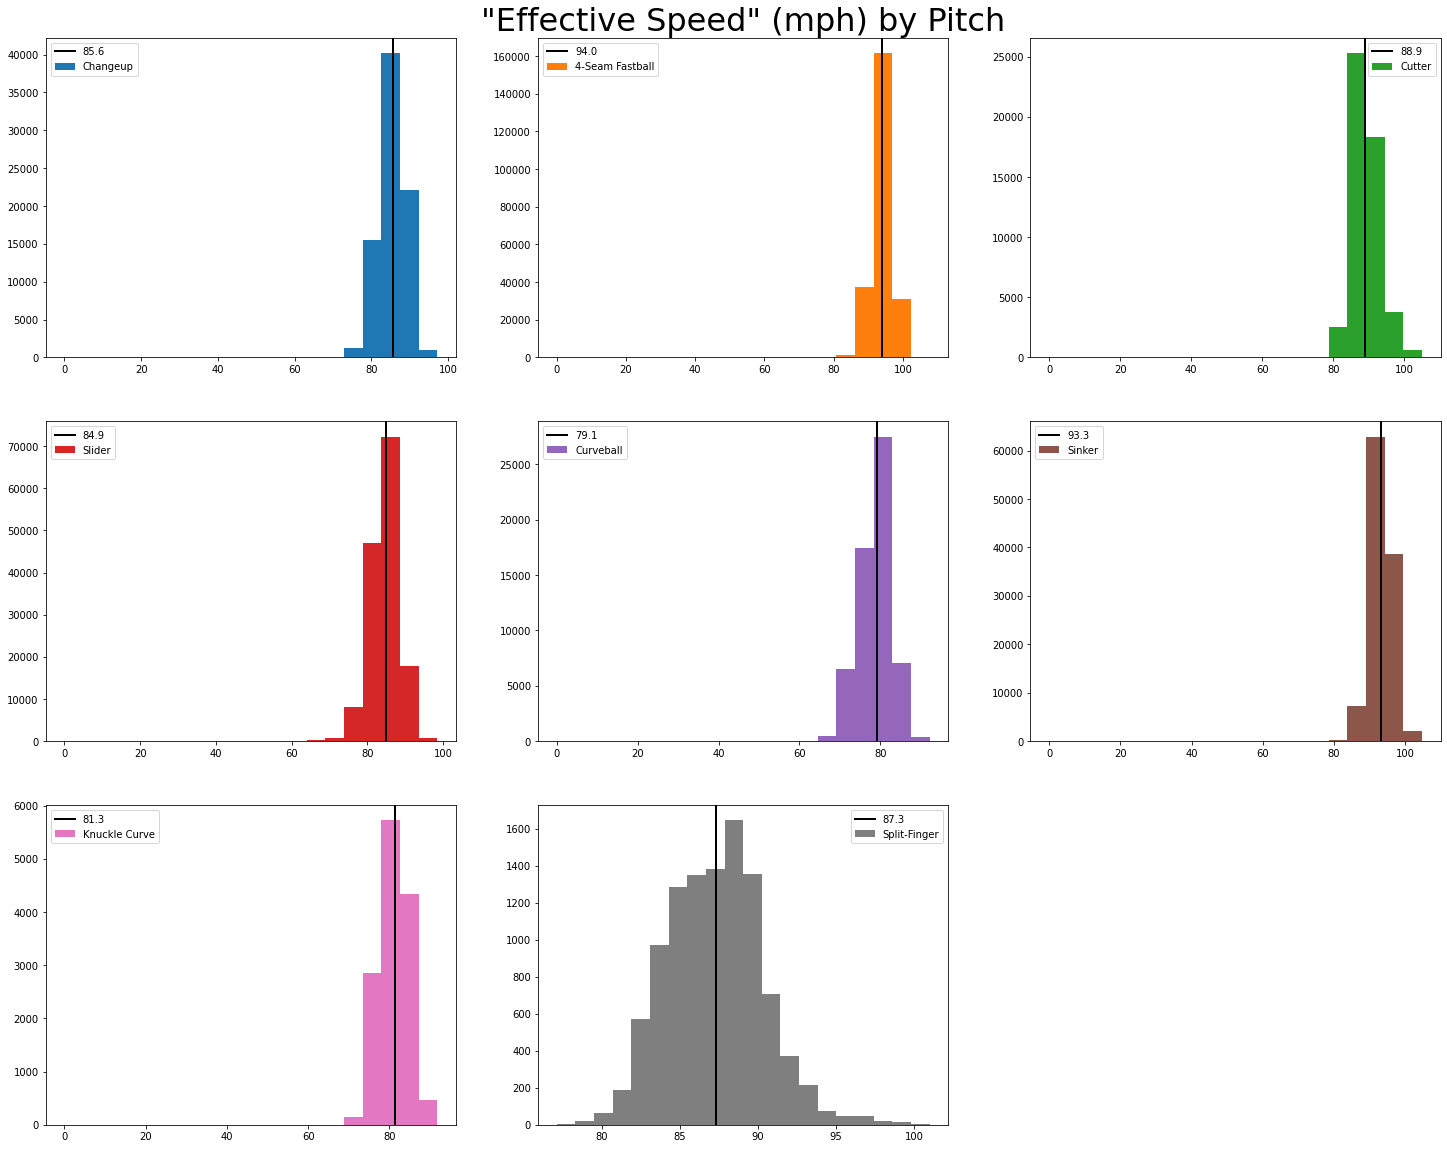

In [24]:
# Generate a pyplot figure
fig = plt.figure(figsize = (25,20))

# Set title
plt.title('"Effective Speed" (mph) by Pitch', fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each unique pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For effective speed (release speed & extension), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  # Iterate to next color in rotation
  c = next(colors)["color"]

  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.effective_speed[df.pitch_name==val]
  
  ax = fig.add_subplot(3, 3, i+1)
  ax.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax.legend()

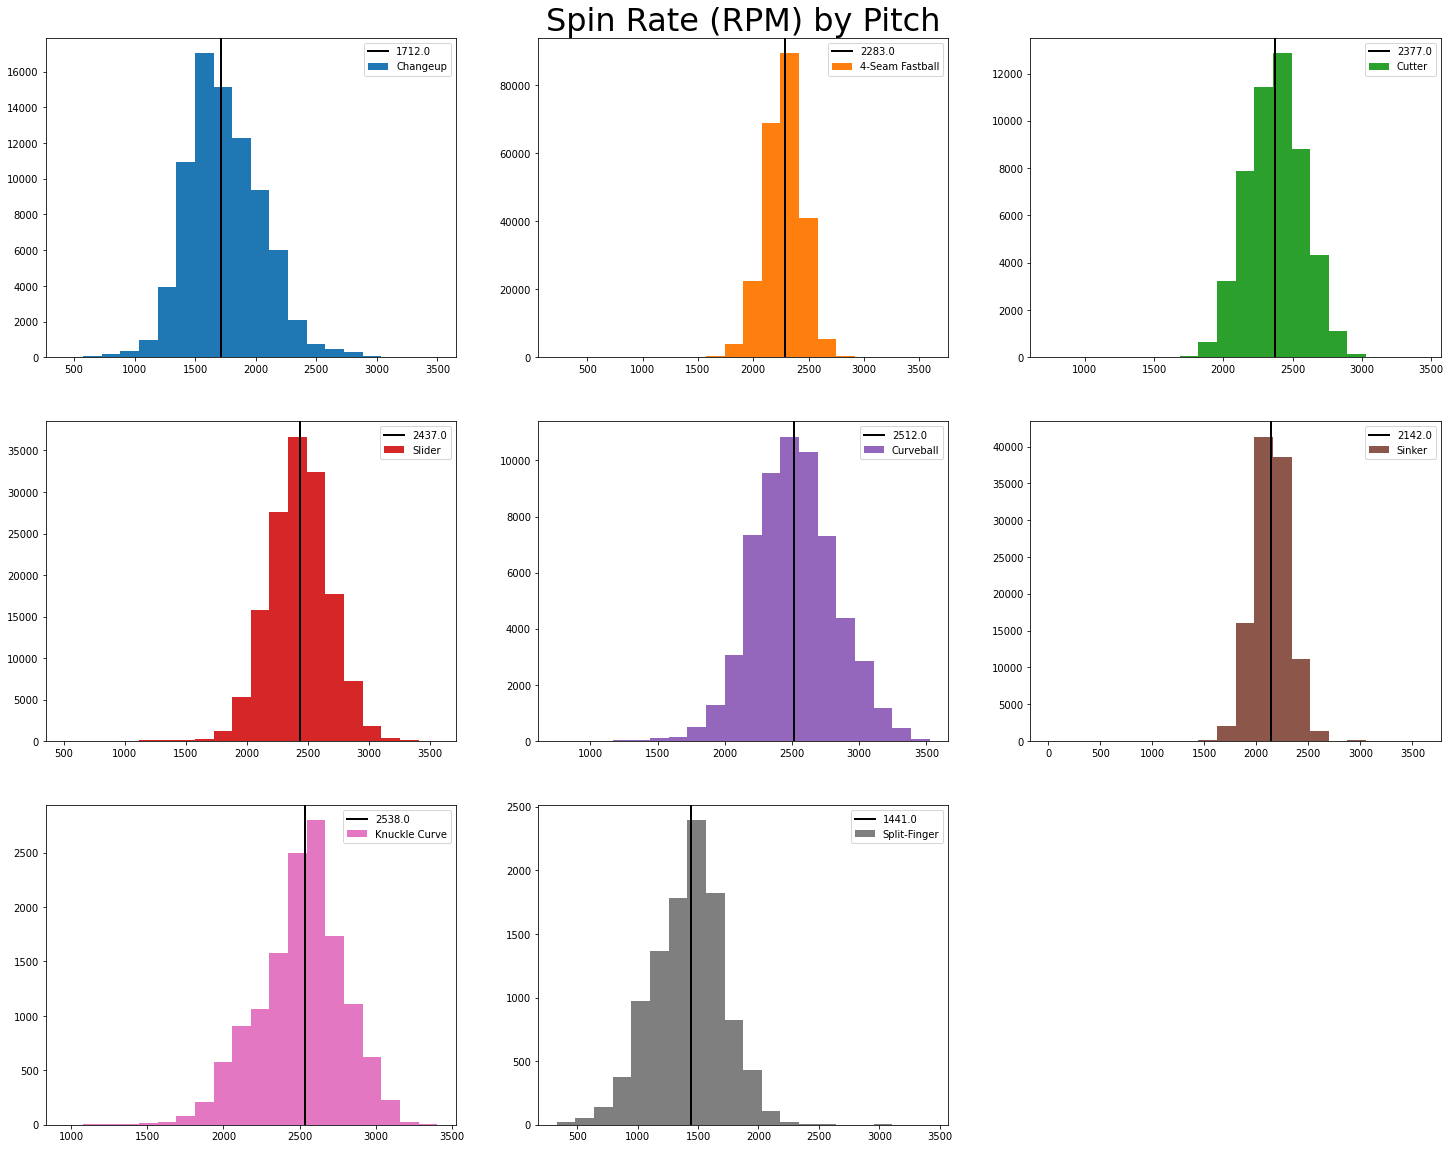

In [25]:
# Generate a pyplot figure
fig2 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Rate (RPM) by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.release_spin_rate[df.pitch_name==val]
  ax2 = fig2.add_subplot(3, 3, i+1)
  ax2.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax2.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax2.legend()

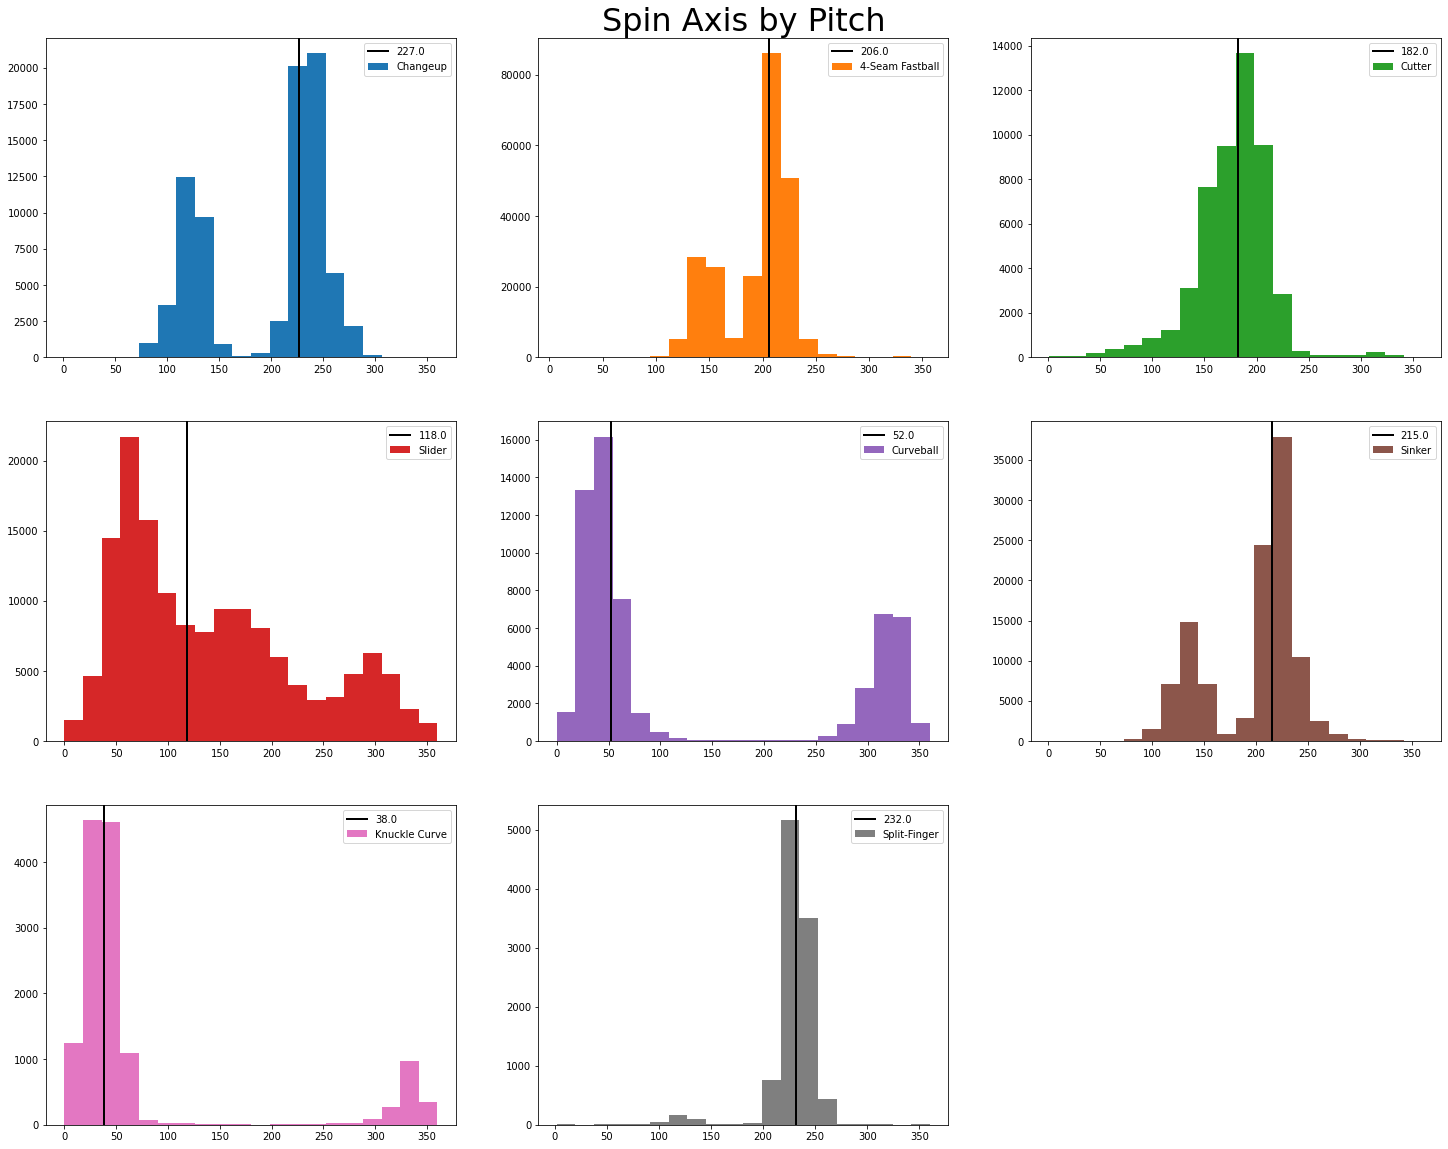

In [26]:
# Generate a pyplot figure
fig3 = plt.figure(figsize = (25,20))

# Set title
plt.title("Spin Axis by Pitch", fontsize=32)
plt.axis('off')

# Retrieve 10 default colors to use for each  pitch
colors = plt.rcParams["axes.prop_cycle"]()

# For release spin rate (unit: RPM), generate a histogram for each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Filter to data of interest, add as a subplot for each pitch
  x = df.spin_axis[df.pitch_name==val]
  ax3 = fig3.add_subplot(3, 3, i+1)
  ax3.hist(x,label=val, color = c, bins=20)

  # Draw line at each pitch's median to visualize best descriptive stat for normal and non-normal distibutions
  ax3.axvline(x.median(), color='k', linestyle='solid', linewidth=2, label = x.median())
  ax3.legend()

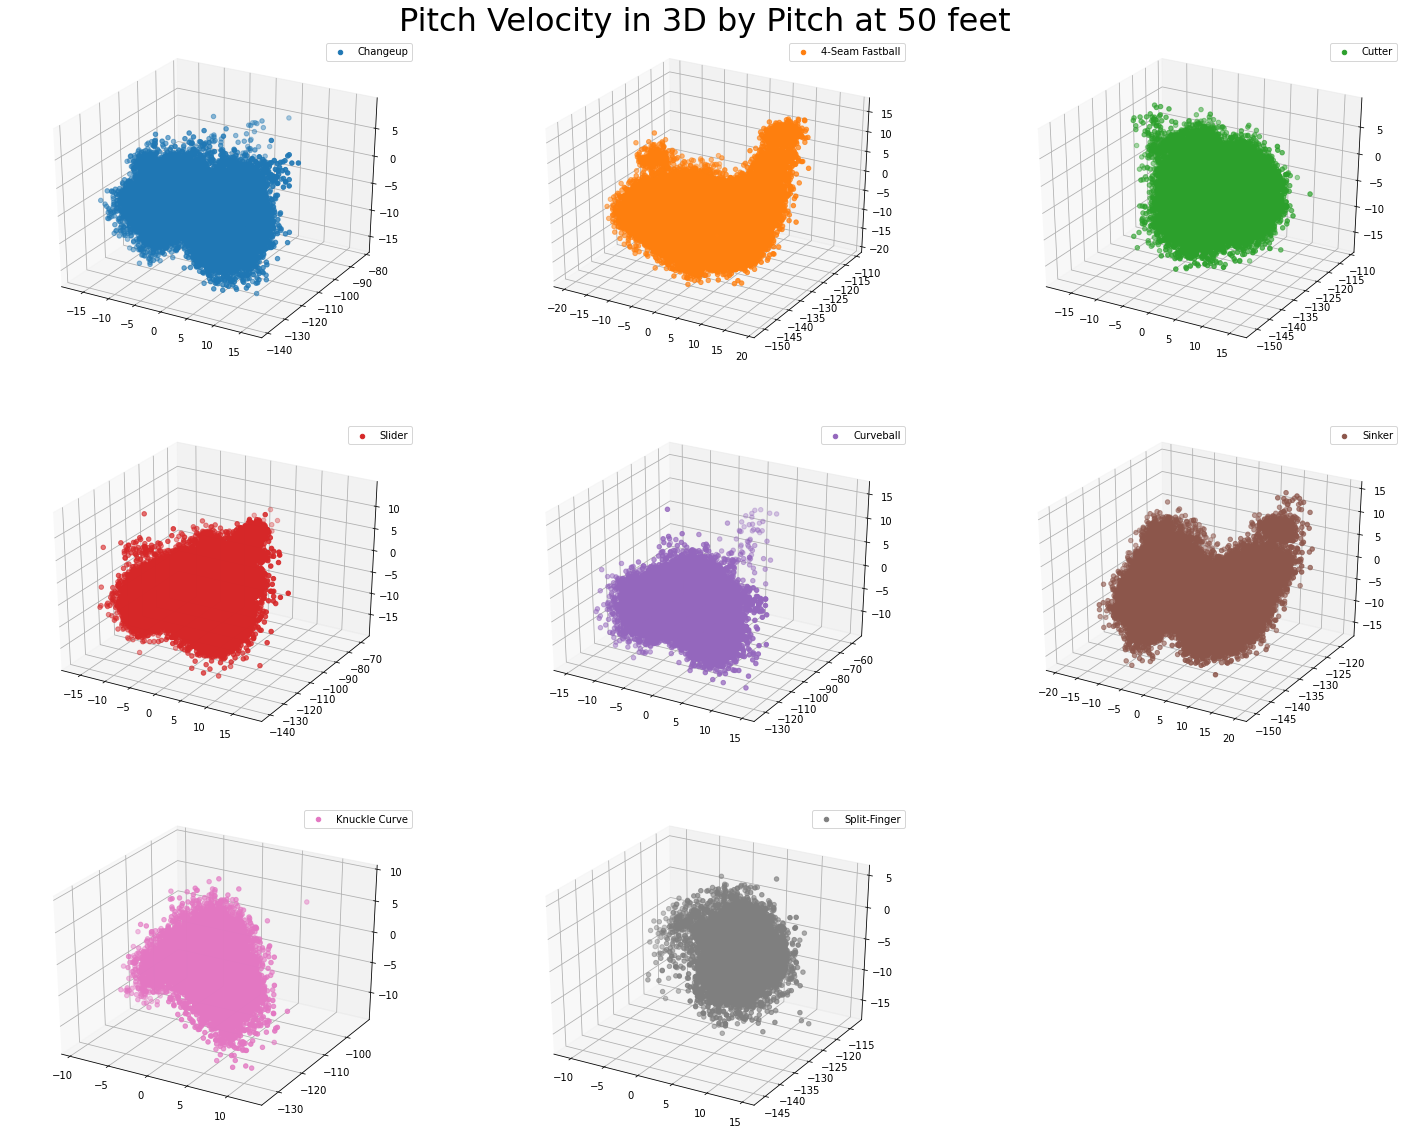

In [27]:
# 3D Scatterplot of Pitch Velocity at x=y=z=50 feet
fig_3D = plt.figure(figsize = (25,20))

# Set title
plt.title("Pitch Velocity in 3D by Pitch at 50 feet", fontsize = 32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

# For velocity in R^3 at 50 feet, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]

  # Add 3D subplot to visualize 3D data
  ax_3D = fig_3D.add_subplot(3, 3, i+1, projection='3d')

  # Get 3D data, plot
  x = np.asarray(df.vx0[df.pitch_name==val], dtype= 'float')
  y = np.asarray(df.vy0[df.pitch_name==val], dtype= 'float')
  z = np.asarray(df.vz0[df.pitch_name==val], dtype= 'float')

  ax_3D.scatter(x, y, z, label=val, color = c)
  ax_3D.legend()

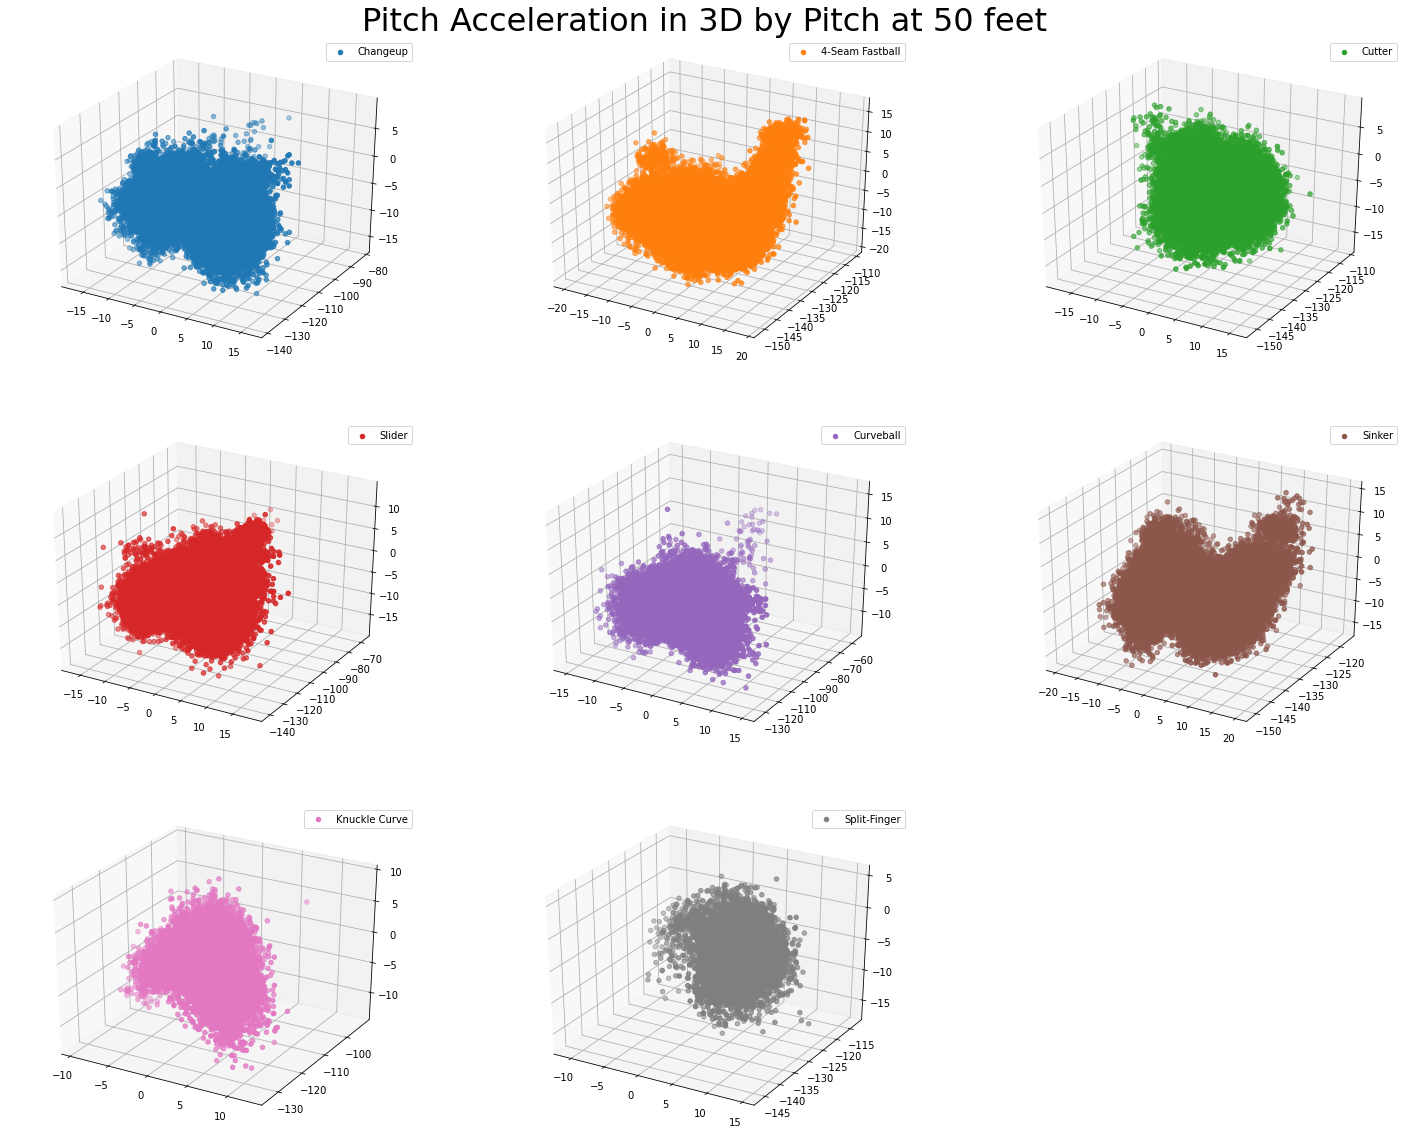

In [28]:
# 3D Scatterplot of Pitch acceleration in x,y,z dimensions at 50 feet
fig2_3D = plt.figure(figsize = (25,20))

# Set title
plt.title("Pitch Acceleration in 3D by Pitch at 50 feet", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  # Add a 3D subplot to visualize 3D data
  ax2_3D = fig2_3D.add_subplot(3, 3, i+1, projection='3d')

  # Get 3D data, plot
  x = np.asarray(df.vx0[df.pitch_name==val], dtype= 'float')
  y = np.asarray(df.vy0[df.pitch_name==val], dtype= 'float')
  z = np.asarray(df.vz0[df.pitch_name==val], dtype= 'float')

  ax2_3D.scatter(x,y,z,label=val, color = c)
  ax2_3D.legend()

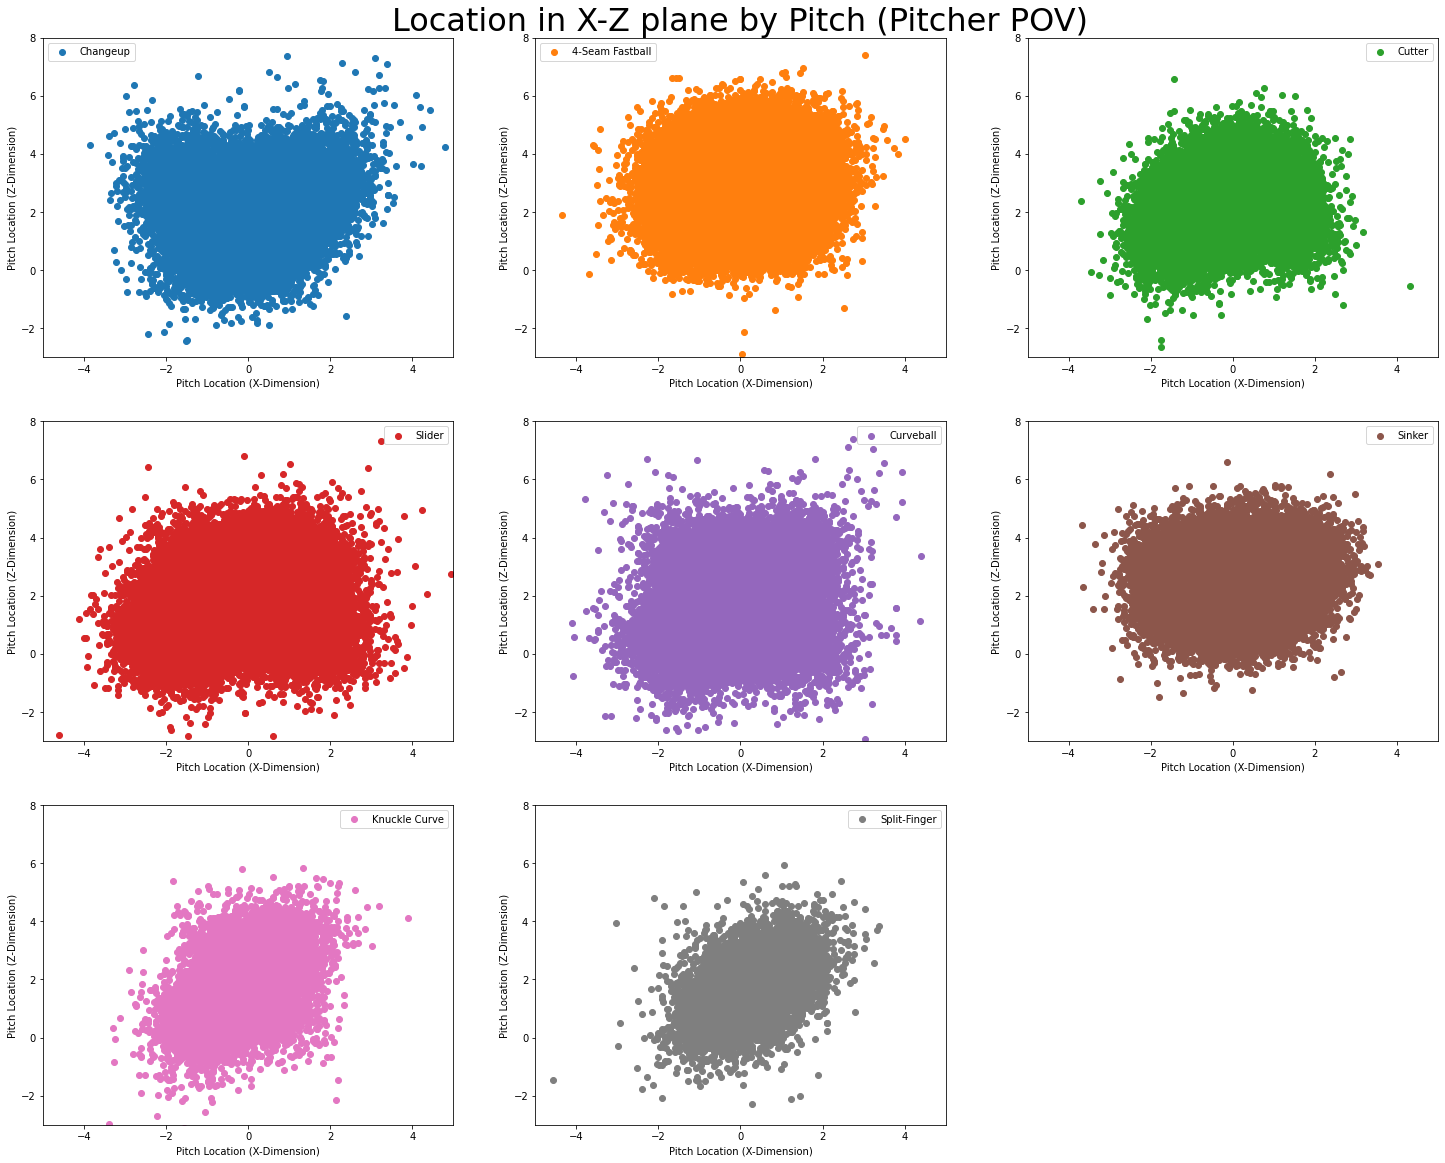

In [29]:
# Plate location plots
fig4 = plt.figure(figsize = (25,20))
plt.title("Location in X-Z plane by Pitch (Pitcher POV)", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  ax4 = fig4.add_subplot(3, 3, i+1)

  # Since it's from the catcher's perspective, we flip the pitch's location in the x-axis to get a pitcher's perspective
  x = df.plate_x[df.pitch_name==val] * -1
  y = df.plate_z[df.pitch_name==val]
  
  ax4.scatter(x=x, y=y,label=val, color = c)
  
  ax4.set_xlim(-5, 5)
  ax4.set_ylim(-3, 8)
  ax4.set_xlabel("Pitch Location (X-Dimension)")
  ax4.set_ylabel("Pitch Location (Z-Dimension)")
  ax4.legend()

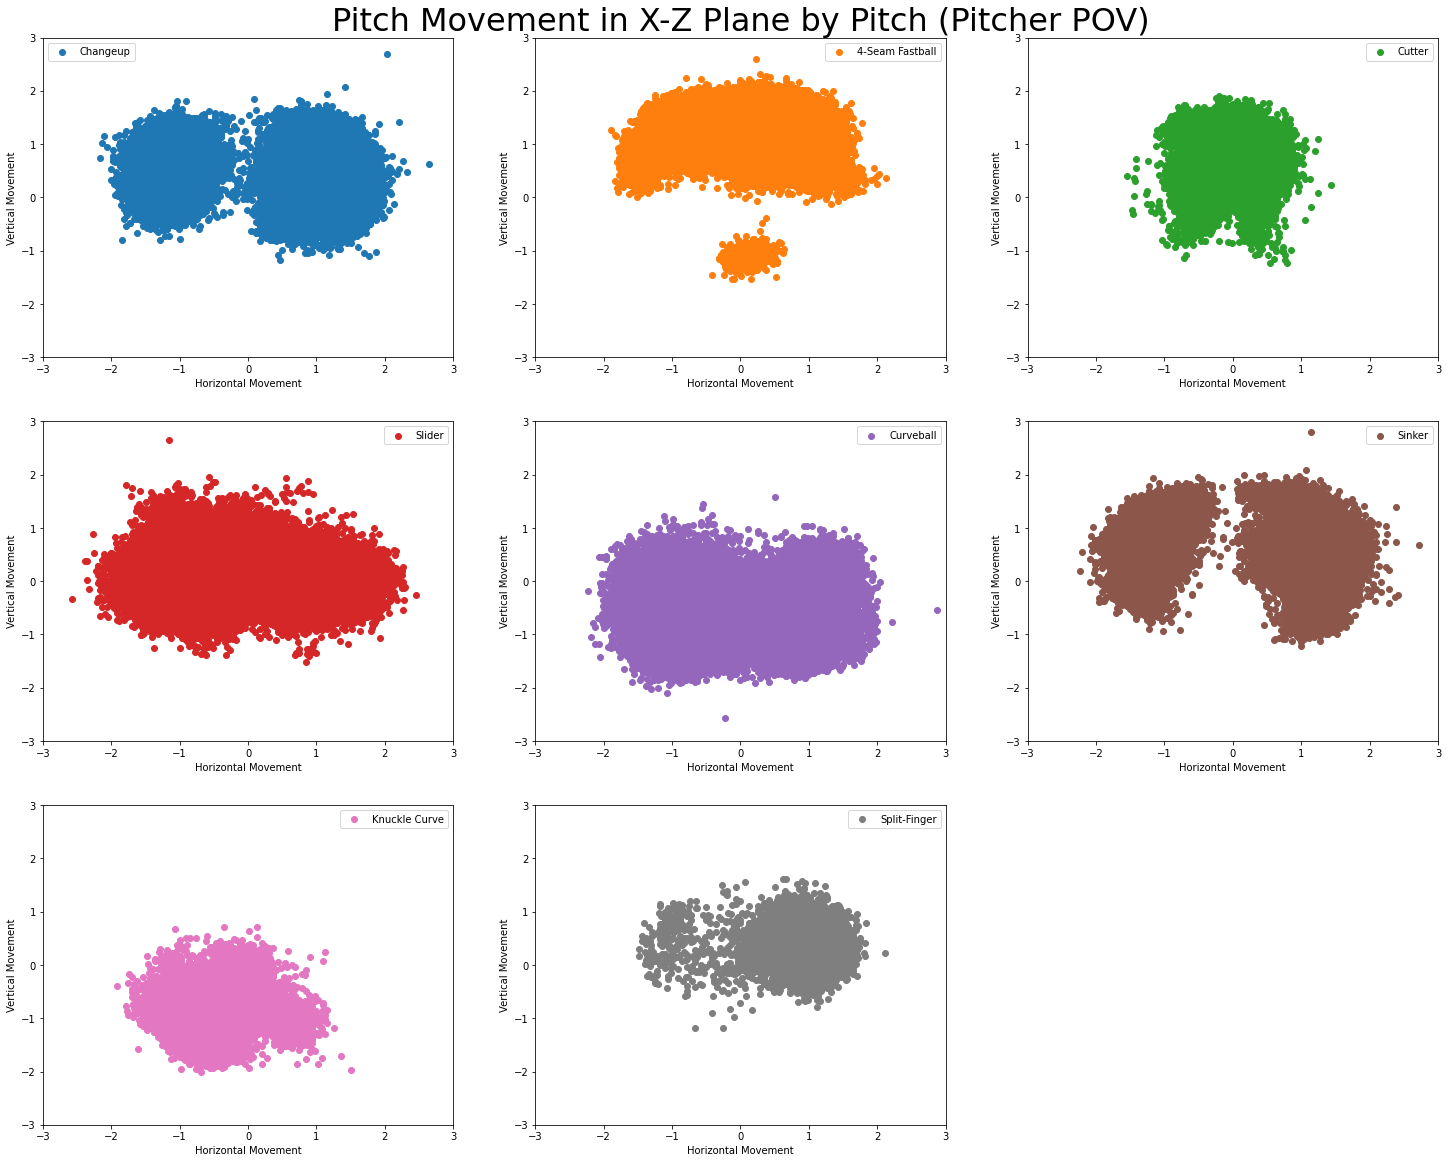

In [30]:
# Pitch movement scatterplots
fig5 = plt.figure(figsize = (25,20))
plt.title("Pitch Movement in X-Z Plane by Pitch (Pitcher POV)", fontsize=32)
plt.axis('off')

colors = plt.rcParams["axes.prop_cycle"]()

for i, val in enumerate(df.pitch_name.unique()):
  c = next(colors)["color"]
  
  ax5 = fig5.add_subplot(3, 3, i+1)

  # Since it's from the catcher's perspective, we flip the movement in the x-axis to get a pitcher's perspective
  x = df.pfx_x[df.pitch_name==val] * -1
  y = df.pfx_z[df.pitch_name==val]
  ax5.scatter(x = x,y = y,label=val, color = c)
  
  ax5.set_xlim(-3, 3)
  ax5.set_ylim(-3, 3)
  ax5.set_xlabel("Horizontal Movement")
  ax5.set_ylabel("Vertical Movement")
  ax5.legend()

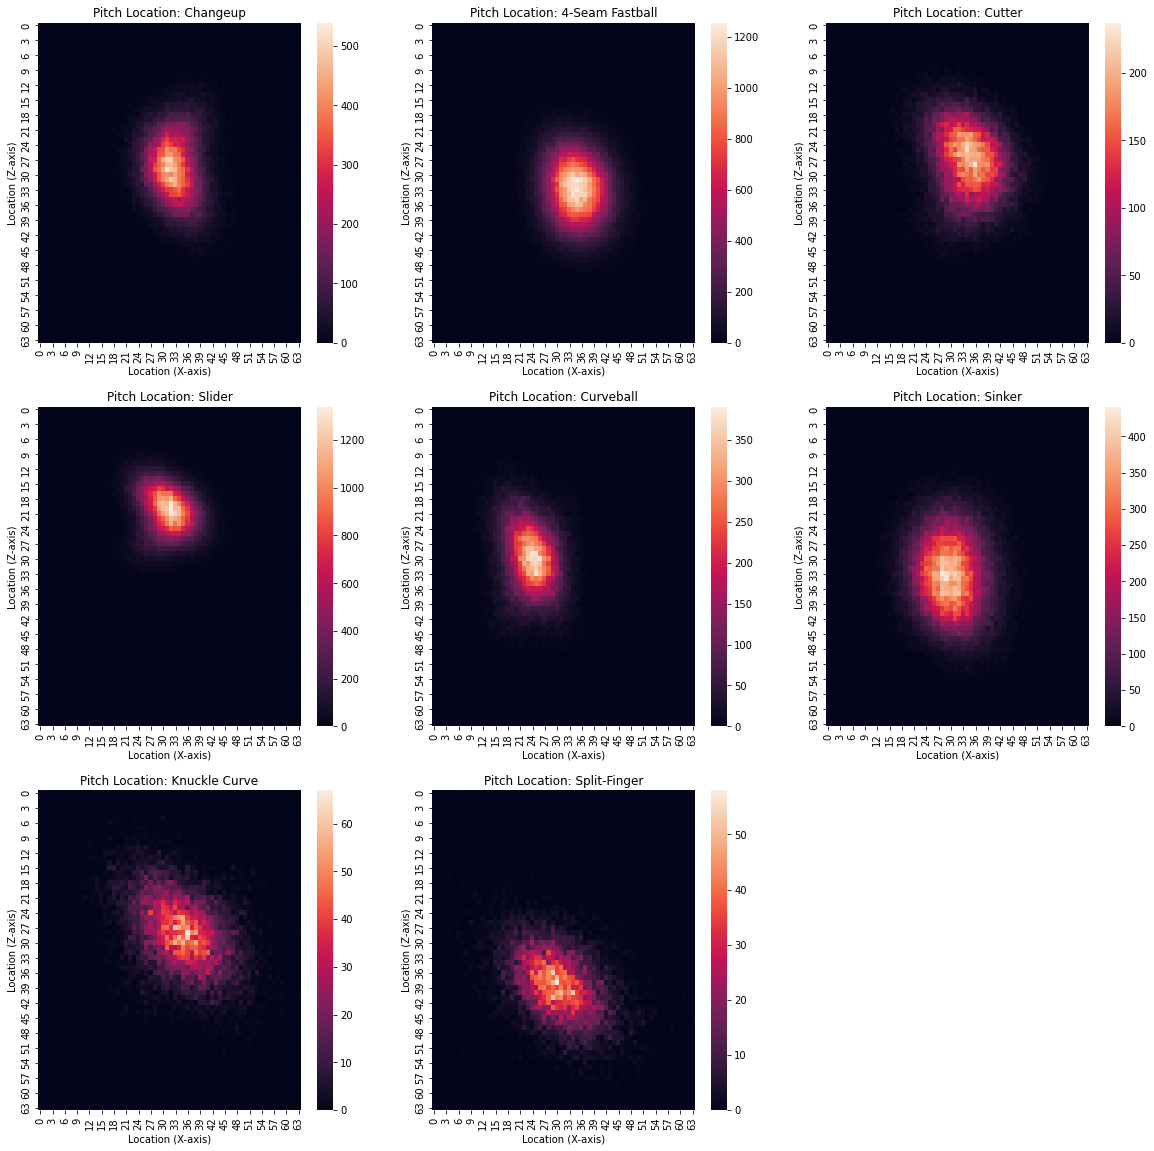

In [31]:
fig6 = plt.figure(figsize = (20,20))

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  ax6 = fig6.add_subplot(3, 3, i+1)

  # Generate location data, convert into 2D array as a heatmap
  x = df.plate_x[df.pitch_name==val] * -1
  y = df.plate_z[df.pitch_name==val]

  heatmap, xedges, yedges = np.histogram2d(x, y, bins=(64,64))
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  
  # Plot as heatmap
  sns.heatmap(heatmap)
  ax6.set(title = f"Pitch Location: {val}",
          xlabel = 'Location (X-axis)',
          ylabel = 'Location (Z-axis)')

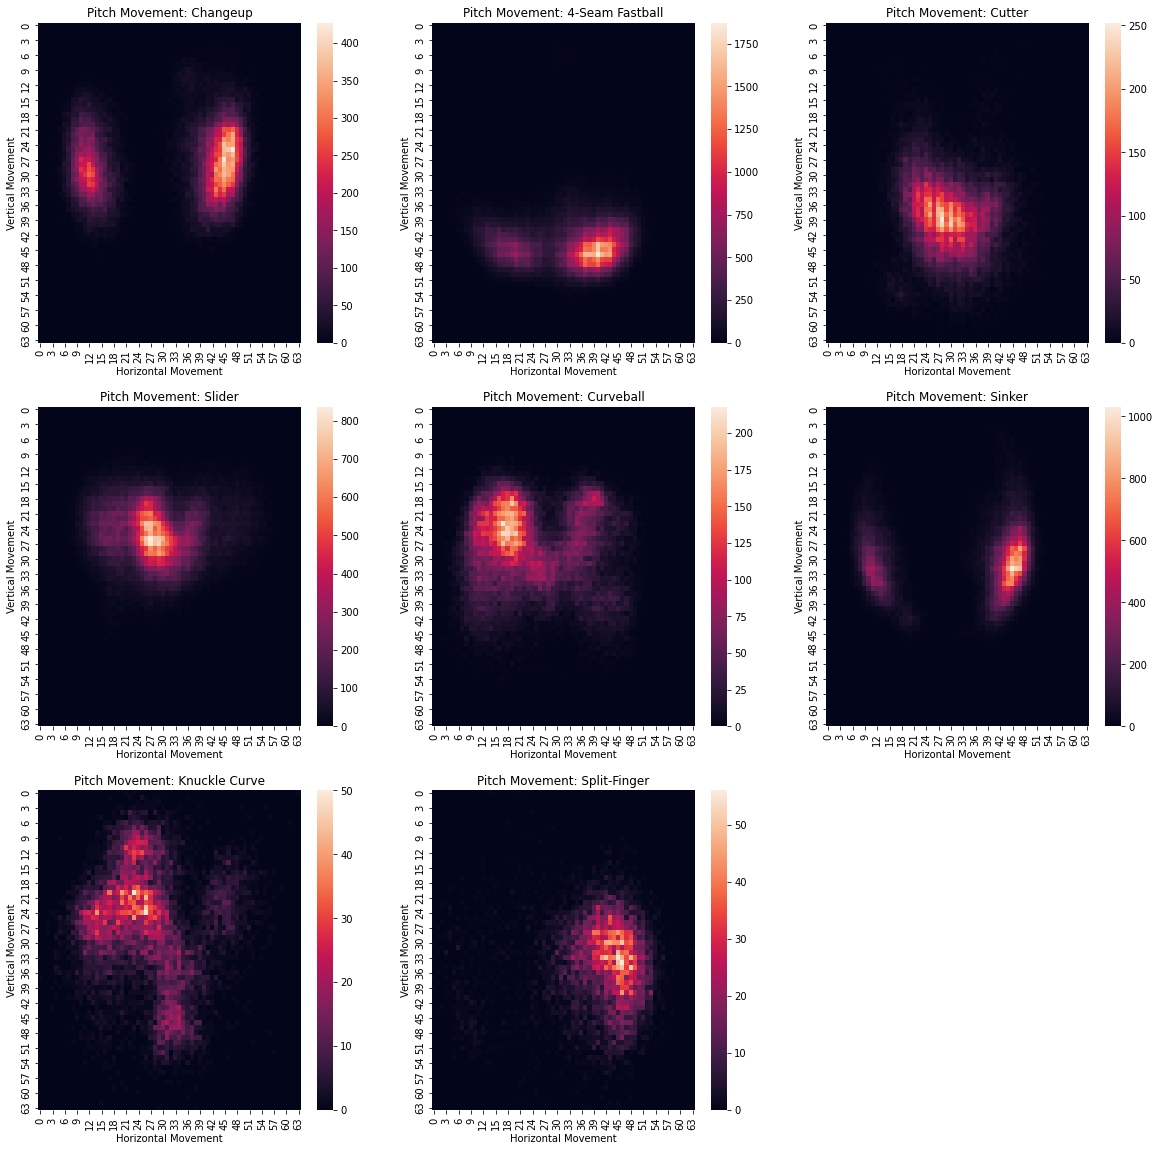

In [32]:
fig7 = plt.figure(figsize = (20,20))

# For each of our variables of interest, generate a scatterplot of each pitch
for i, val in enumerate(df.pitch_name.unique()):
  ax7 = fig7.add_subplot(3, 3, i+1)

  # Generate 3D data, convert to NumPy 2D Array
  # Flipped to match 2D Scatterplot for Movement
  x = df.pfx_x[df.pitch_name==val] * -1
  y = df.pfx_z[df.pitch_name==val]

  heatmap, xedges, yedges = np.histogram2d(y, x, bins=(64,64))
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  
  # Plot
  sns.heatmap(heatmap)
  ax7.set(title = f"Pitch Movement: {val}",
          xlabel = 'Horizontal Movement',
          ylabel = 'Vertical Movement')



## Preprocessing

### Encoding Categorical Columns

In [33]:
X = df.drop(['pitcher',	'player_name', 'pitch_name'], axis=1)
y = df['pitch_name']

In [34]:
label_encoder = LabelEncoder()    

X['p_throws'] = label_encoder.fit_transform(X['p_throws'])
X

,p_throws,release_spin_rate,release_speed,effective_speed,spin_axis,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,plate_x,plate_z
0,1,1771,80.8,81.5,213,3.558407,-117.646983,-4.681001,-13.171122,21.657751,-24.034138,-1.34,0.8,-0.32,2.24
1,1,2434,97.7,98.1,189,2.238826,-142.091777,-8.96856,-2.851911,33.061824,-8.887788,-0.17,1.58,0.1,2.59
2,1,1856,84.9,85.2,212,6.936655,-123.422405,-5.325648,-13.889678,25.079523,-22.776142,-1.22,0.83,1.35,2.31
3,1,2258,97.2,97.5,192,-0.055174,-141.325311,-10.022382,-1.712935,33.111733,-6.725581,-0.13,1.74,-0.55,2.3
4,1,2348,86.2,86.7,127,0.906464,-125.636009,-2.473559,6.513804,24.352439,-31.861988,0.63,0.0,0.36,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704271,1,1314,91.8,93.8,234,2.903163,-133.823709,-4.599003,-4.20002,23.66655,-30.580581,-0.3,0.08,-0.89,2.05
704272,1,2440,86.9,88.6,92,1.715667,-126.691081,-4.680738,11.802514,22.704431,-25.935414,1.11,0.51,-0.64,1.74
704273,1,2320,99.2,100.7,207,10.013029,-144.212678,-7.642544,-1.416227,28.775681,-19.306867,0.04,0.81,1.53,1.84
704274,1,2164,97.9,99.9,206,4.033907,-142.625616,-7.606169,0.276497,27.659035,-16.289654,0.08,1.06,-0.62,2.01


In [35]:
X.dtypes

p_throws               int64
release_spin_rate      Int64
release_speed        Float64
effective_speed      Float64
spin_axis              Int64
vx0                  Float64
vy0                  Float64
vz0                  Float64
ax                   Float64
ay                   Float64
az                   Float64
pfx_x                Float64
pfx_z                Float64
plate_x              Float64
plate_z              Float64
dtype: object

In [36]:
y

0                Changeup
1         4-Seam Fastball
2                Changeup
3         4-Seam Fastball
4                  Cutter
               ...       
704271       Split-Finger
704272             Slider
704273    4-Seam Fastball
704274    4-Seam Fastball
704275    4-Seam Fastball
Name: pitch_name, Length: 704276, dtype: object

In [37]:
label_encoder2 = LabelEncoder()

y = label_encoder2.fit_transform(y)
y

array([1, 0, 1, ..., 0, 0, 0])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state=0,
                                                    stratify = y) 

In [39]:
# Stratified sampling
def to_freq_dict(counter):
  ret_di = {}

  counter_total = sum(i[1] for i in counter)
  
  for i in counter:
    ret_di[i[0]] = round((i[1] / counter_total) * 100 , 1)

  return ret_di

pitch_freq = to_freq_dict(sorted(Counter(y).items(), key=itemgetter(0)))
y_train_freq = to_freq_dict(sorted(Counter(y_train).items(), key=itemgetter(0)))
y_test_freq = to_freq_dict(sorted(Counter(y_test).items(), key=itemgetter(0)))

print(pitch_freq)
print(y_train_freq)
print(y_test_freq)

{0: 33.0, 1: 11.4, 2: 8.4, 3: 7.2, 4: 1.9, 5: 15.8, 6: 20.9, 7: 1.5}
{0: 33.0, 1: 11.4, 2: 8.4, 3: 7.2, 4: 1.9, 5: 15.8, 6: 20.9, 7: 1.5}
{0: 33.0, 1: 11.4, 2: 8.4, 3: 7.2, 4: 1.9, 5: 15.8, 6: 20.9, 7: 1.5}


In [40]:
pitch_df = pd.DataFrame()
pitch_df['label'] = df['pitch_name']
pitch_df['encoded'] = y.tolist()
pitch_encoded = round( pitch_df.value_counts(sort=False, ascending=False) / len(df) * 100, 1)#/

pitch_encoded

label            encoded
4-Seam Fastball  0          33.0
Changeup         1          11.4
Curveball        2           8.4
Cutter           3           7.2
Knuckle Curve    4           1.9
Sinker           5          15.8
Slider           6          20.9
Split-Finger     7           1.5
dtype: float64

### Standardization

In [41]:
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

## Model Construction

### K-Nearest Neighbors

In [42]:
# Default neighbors = 5, Compares each instance to the closest 5 instances around it, and classifies each instance based on its proximity to other instances
KNN = KNeighborsClassifier()

# Fit model and predict
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)

In [43]:
# Create confusion matrix: view the 
# Adding up each row is the actual number of instances per class,
# Adding up each column is the predicted number of instances per class

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[44703,    40,     0,   429,     0,  1200,    71,     1],
       [   94, 14842,     2,    11,     1,   599,    25,   434],
       [    0,     4,  9975,    22,   440,     0,  1445,     0],
       [  731,    11,    36,  7156,     4,    17,  2160,     1],
       [    0,     3,  1000,     4,  1461,     0,   235,     0],
       [ 2183,   501,     0,    18,     0, 19500,     5,     8],
       [   87,    55,  1085,  1844,   109,    11, 26218,     8],
       [    4,   915,     1,     2,     0,    39,     4,  1102]])

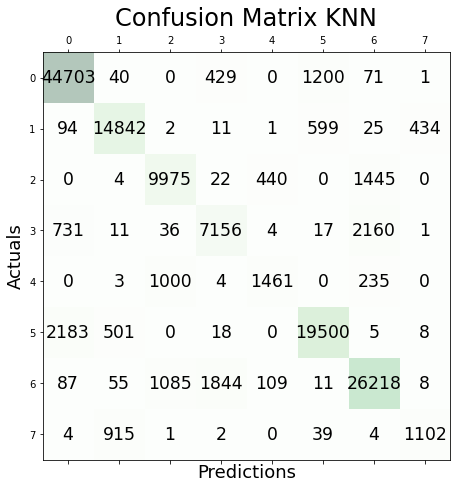

In [44]:
# Create confusion matrix in plot for better visualization

fig, ax = plt.subplots(figsize=(7.5, 7.5))
# matshow command: turn array of nested arrays (i.e. matrix) into a matrix plot
ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.3)

# For loop 1: loops over each row of the matrix
for i in range(conf_matrix.shape[0]):
    # For loop 2: loops through each value in each matrix row, adds value in text to matrix plot
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix KNN', fontsize=24)
plt.show()

In [45]:
# Normalizes matrix, replaces absolute number of errors per class to
# proportion of errors per class

# Note: normalization is done due to the differrent frequency for each class (aka pitch)
rows = conf_matrix.sum(axis = 1, keepdims = True)
normalized_matrix = conf_matrix / rows

# Diagonals fill for 0% error when predicting each class correctly
np.fill_diagonal(normalized_matrix, 0)
normalized_matrix = np.round_(normalized_matrix, 4)
normalized_matrix

array([[0.000e+00, 9.000e-04, 0.000e+00, 9.200e-03, 0.000e+00, 2.580e-02,
        1.500e-03, 0.000e+00],
       [5.900e-03, 0.000e+00, 1.000e-04, 7.000e-04, 1.000e-04, 3.740e-02,
        1.600e-03, 2.710e-02],
       [0.000e+00, 3.000e-04, 0.000e+00, 1.900e-03, 3.700e-02, 0.000e+00,
        1.216e-01, 0.000e+00],
       [7.230e-02, 1.100e-03, 3.600e-03, 0.000e+00, 4.000e-04, 1.700e-03,
        2.135e-01, 1.000e-04],
       [0.000e+00, 1.100e-03, 3.700e-01, 1.500e-03, 0.000e+00, 0.000e+00,
        8.690e-02, 0.000e+00],
       [9.830e-02, 2.260e-02, 0.000e+00, 8.000e-04, 0.000e+00, 0.000e+00,
        2.000e-04, 4.000e-04],
       [3.000e-03, 1.900e-03, 3.690e-02, 6.270e-02, 3.700e-03, 4.000e-04,
        0.000e+00, 3.000e-04],
       [1.900e-03, 4.427e-01, 5.000e-04, 1.000e-03, 0.000e+00, 1.890e-02,
        1.900e-03, 0.000e+00]])

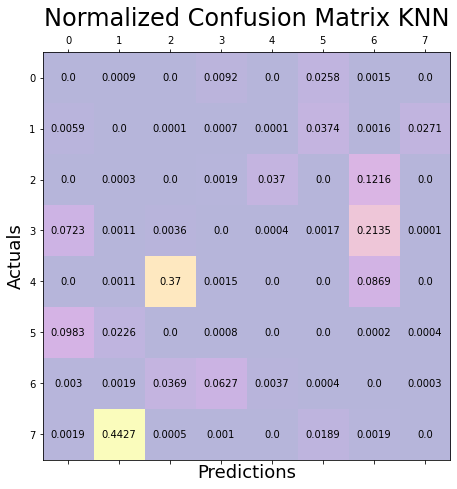

In [46]:
# Create confusion matrix in plot for better visualization

fig2, ax2 = plt.subplots(figsize=(7.5, 7.5))
# matshow command: turn array of nested arrays (i.e. matrix) into a matrix plot
ax2.matshow(normalized_matrix, cmap=plt.cm.plasma, alpha=0.3)

# For loop 1: loops over each row of the matrix
for i in range(normalized_matrix.shape[0]):
  # For loop 2: loops through each value in each matrix row, adds value in text to matrix plot
  for j in range(normalized_matrix.shape[1]):
    ax2.text(x=j, y=i,s=normalized_matrix[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix KNN', fontsize=24)
plt.show()

In [47]:
# Recall what pitches were encoded to what class number
pitch_encoded

label            encoded
4-Seam Fastball  0          33.0
Changeup         1          11.4
Curveball        2           8.4
Cutter           3           7.2
Knuckle Curve    4           1.9
Sinker           5          15.8
Slider           6          20.9
Split-Finger     7           1.5
dtype: float64

Findings:
* Some sinkers are misclassified as 4-seams
* Many predicted curveballs are actually knuckle-curves
*   The most alarming error is in splitters that are predicted as changeups. The inverse is not true, meaning that the model is not good at telling splitters from changeups given an instance of a splitter, but is good at predicting instances of changeups correctly and telling them from splitters.
*   Curveballs (both kinds) and cutters are misclassified as sliders



In [48]:
# Give model's accuracy scores for predicting on testing and training sets 
print("Testing set accuracy: ", KNN.score(X_test, y_test))
print("Training set accuracy: ", KNN.score(X_train, y_train))

Testing set accuracy:  0.887125859033339
Training set accuracy:  0.9206808420006389


In [50]:
# Precision: True Positive Rate (TP / TP + FP)
# Recall: Actual Positive Rate (TP / TP + FN)
# F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     46444
           1       0.91      0.93      0.92     16008
           2       0.82      0.84      0.83     11886
           3       0.75      0.71      0.73     10116
           4       0.73      0.54      0.62      2703
           5       0.91      0.88      0.89     22215
           6       0.87      0.89      0.88     29417
           7       0.71      0.53      0.61      2067

    accuracy                           0.89    140856
   macro avg       0.83      0.78      0.80    140856
weighted avg       0.88      0.89      0.89    140856



In [51]:
# Training set split into 5 different folds, one trained on test set and prediction ran
y_cv_pred = cross_val_predict(KNN, X_train, y_train, cv=5)

#F1 Score averaged across all KNN cross-validated folds
f1_score(y_train, y_cv_pred, average="macro")

0.7993239915822817

### Fine-Tuning

In [ ]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [11, 15, 21]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...n_neighbors=11, weights=uniform;, score=0.887 total time= 2.1min


In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
grid_search = KNeighborsClassifier(n_neighbors= 10, weights = 'distance')
grid_search.fit(X_train, y_train)

In [ ]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
# Create confusion matrix: 
# Adding up each row is the actual number of instances per class,
# Adding up each column is the predicted number of instances per class
conf_matrix_grid = confusion_matrix(y_pred, y_test)


# Normalizes matrix, replaces absolute number of errors per class to
# proportion of errors per class

# Note: normalization is done due to the differrent frequency for each class (aka pitch)
rows = conf_matrix_grid.sum(axis = 1, keepdims = True)
normalized_matrix = conf_matrix_grid / rows

# Diagonals fill for 0% error when predicting each class correctly
np.fill_diagonal(normalized_matrix, 0)
normalized_matrix = np.round_(normalized_matrix, 4)
normalized_matrix

In [ ]:
# Create confusion matrix in plot for better visualization

fig3, ax3 = plt.subplots(figsize=(7.5, 7.5))
# matshow command: turn array of nested arrays (i.e. matrix) into a matrix plot
ax3.matshow(normalized_matrix, cmap=plt.cm.Wistia, alpha=0.3)

# For loop 1: loops over each row of the matrix
for i in range(normalized_matrix.shape[0]):
  # For loop 2: loops through each value in each matrix row, adds value in text to matrix plot
  for j in range(normalized_matrix.shape[1]):
    ax3.text(x=j, y=i,s=normalized_matrix[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Normalized Confusion Matrix KNN', fontsize=24)
plt.show()

In [ ]:
# Recall what pitches were encoded to what class number
pitch_encoded

In [ ]:
# Precision: True Positive Rate (TP / TP + FP)
# Recall: Actual Positive Rate (TP / TP + FN)
# F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
print(classification_report(y_test, y_pred))

In [ ]:
# Training set split into 5 different folds, one trained on test set and prediction ran
y_cv_pred = cross_val_predict(grid_search, X_train, y_train, cv=5)

#F1 Score averaged across all KNN cross-validated folds
f1_score(y_train, y_cv_pred, average="macro")